## Human-compatibility analysis

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

IL_COLOR = 'dodgerblue'
sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')

### Configurations

In [8]:
SCENE_INFO_PATH = '../evaluation/scene_info/info_dict_train_no_tl'

### Load dictionary that contains information about the number of intersecting paths per vehicle id

In [13]:
scene_to_paths_dict["tfrecord-00000-of-01000_469.json"].keys()

dict_keys(['veh_id', 'intersecting_paths', 'min_step_diff', 'total_intersecting_paths'])

In [10]:
# Load dict with number of intersecting paths per scene
with open(SCENE_INFO_PATH, 'rb') as handle:
    scene_to_paths_dict = pickle.load(handle)

# Create an empty dataframe
df_intersect = pd.DataFrame(columns=['traffic_scene', 'veh_id', 'intersecting_paths', 'min_step_diff'])

# Populate the dataframe
for traffic_scene, data in scene_to_paths_dict.items():
    veh_ids = data['veh_id']
    intersecting_paths = data['intersecting_paths']
    step_diff = data['min_step_diff']

    # Repeat traffic_scene for each veh_id
    traffic_scene_col = [traffic_scene] * len(veh_ids)

    # Append to the dataframe
    df_intersect = pd.concat([df_intersect, pd.DataFrame(list(zip(traffic_scene_col, veh_ids, intersecting_paths, step_diff)),
                                     columns=['traffic_scene', 'veh_id', 'intersecting_paths', 'min_step_diff'])])

# Reset index
df_intersect.reset_index(drop=True, inplace=True)

In [11]:
df_intersect

,traffic_scene,veh_id,intersecting_paths,min_step_diff
0,tfrecord-00000-of-01000_469.json,0,2,29.0
1,tfrecord-00000-of-01000_469.json,1,0,NaN
2,tfrecord-00000-of-01000_469.json,2,1,28.0
3,tfrecord-00000-of-01000_469.json,3,2,15.0
4,tfrecord-00000-of-01000_469.json,4,2,20.0
...,...,...,...,...
14390,tfrecord-00999-of-01000_35.json,3,0,NaN
14391,tfrecord-00999-of-01000_35.json,6,0,NaN
14392,tfrecord-00999-of-01000_35.json,8,0,NaN
14393,tfrecord-00999-of-01000_35.json,9,0,NaN


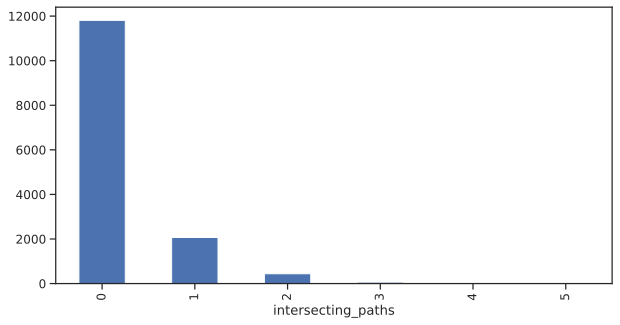

In [16]:
df_intersect.value_counts('intersecting_paths').plot(kind='bar');

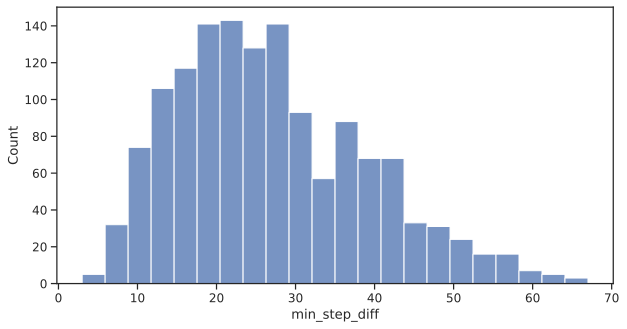

In [6]:
sns.histplot(data=df_intersect, x='min_step_diff', kde=False);

### Load df

In [7]:
#df_hc = pd.read_csv('../df_agg_performance_ip_0131_S50_v2.csv')

### 2.0 Plot stats

In [29]:
BINS = [-1, 0, 1, 2, float('inf')]
LABELS = ['0', '1', '2', '3+']

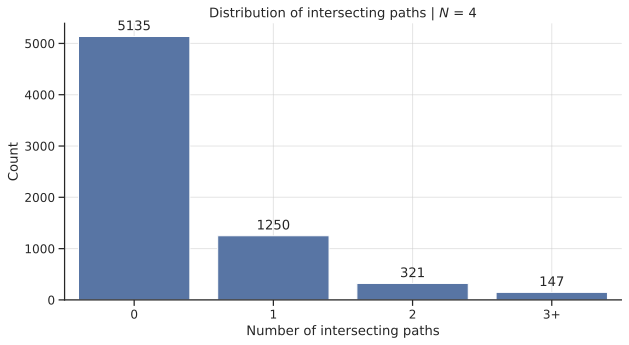

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df, BINS, and LABELS are already defined.

df = df_intersect.reset_index()
df['int_cat'] = pd.cut(df['intersecting_paths'], bins=BINS, labels=LABELS, include_lowest=True)

# Create a countplot
ax = sns.countplot(x='int_cat', data=df)  # By default, it shows counts

# Add numbers on top of the bars for counts
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title(f'Distribution of intersecting paths | $N$ = {df["int_cat"].nunique():,}')
plt.ylabel('Count')
plt.xlabel('Number of intersecting paths')
plt.grid(True, alpha=0.5)
sns.despine()

plt.savefig(f'../evaluation/figures/dist_intersecting_paths_test_set.pdf', bbox_inches="tight")


### Coordination

In [31]:
BINS = [-1, 0, 1, 2, float('inf')]
LABELS = ['0', '1', '2', '3+']

In [32]:
# Aggregate results in self-play evaluation mode
df_sp = df_hc[df_hc['Eval mode'] == 'Self-play']
df_sp['int_path_cat'] = pd.cut(df_sp['veh_int_paths'], bins=BINS, labels=LABELS, include_lowest=True)
df_sp_agg = df_sp.groupby(['Reg. weight', 'int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
df_sp_agg['goal_rate'] = df_sp_agg['goal_rate'] * 100
df_sp_agg['off_road'] = df_sp_agg['off_road'] * 100
df_sp_agg['veh_veh_collision'] = df_sp_agg['veh_veh_collision'] * 100

# Aggregate results in self-play evaluation mode
df_lr = df_hc[df_hc['Eval mode'] == 'Log-replay']
df_lr['int_path_cat'] = pd.cut(df_lr['veh_int_paths'], bins=BINS, labels=LABELS, include_lowest=True)
df_lr_agg = df_lr.groupby(['Reg. weight', 'int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
df_lr_agg['goal_rate'] = df_lr_agg['goal_rate'] * 100
df_lr_agg['off_road'] = df_lr_agg['off_road'] * 100
df_lr_agg['veh_veh_collision'] = df_lr_agg['veh_veh_collision'] * 100

In [33]:
df_hc["Reg. weight"].unique()

array([0.   , 0.01 , 0.025])

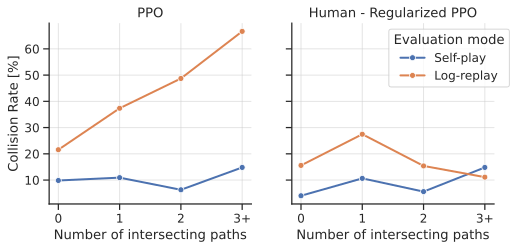

In [36]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2

df_log_replay_reset = df_lr_agg.reset_index()
df_self_play_reset = df_sp_agg.reset_index()

REG_WEIGHT = 0.025

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# PPO
sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_self_play_reset[df_self_play_reset['Reg. weight'] == 0.0], 
    ax=axs[0],
    marker='o',
)

sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_log_replay_reset[df_log_replay_reset['Reg. weight'] == 0.0], 
    ax=axs[0],
    marker='o',
)

# HR-PPO
sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_self_play_reset[df_self_play_reset['Reg. weight'] == REG_WEIGHT], 
    ax=axs[1],
    marker='o',
    label='Self-play',
)

sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_log_replay_reset[df_log_replay_reset['Reg. weight'] == REG_WEIGHT], 
    ax=axs[1],
    marker='o',
    label='Log-replay',
)

axs[1].legend(title='Evaluation mode', loc='upper left', bbox_to_anchor=(.45, 1), facecolor='white')
axs[0].set_title(r'PPO')
axs[1].set_title(r'Human - Regularized PPO')
axs[0].set_ylabel('Collision Rate [%]')
axs[0].set_xlabel('Number of intersecting paths')
axs[1].set_xlabel('Number of intersecting paths')
fig.subplots_adjust(bottom=0.25)
axs[1].grid(True, alpha=0.5), axs[0].grid(True, alpha=0.5)
sns.despine()

plt.savefig(f'../evaluation/figures/coordination_self_play_vs_expert.pdf', bbox_inches="tight")

In [41]:
# df_sp[df_sp["Reg. weight"] == 0.0].groupby('int_path_cat').value_counts()

In [42]:
df_sp['int_path_cat'].value_counts()

int_path_cat
0     5520
1     1071
2      429
3+     162
Name: count, dtype: int64

In [43]:
df_lr['int_path_cat'].value_counts()

int_path_cat
0     2310
1      546
2      117
3+      27
Name: count, dtype: int64

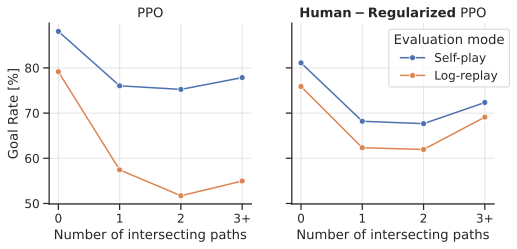

In [93]:
df_log_replay_reset = df_log_replay_agg.reset_index()
df_self_play_reset = df_self_play_agg.reset_index()

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# PPO
sns.lineplot(
    x='int_path_cat', 
    y='goal_rate', 
    data=df_self_play_reset[df_self_play_reset['reg_weight'] == 0.0], 
    ax=axs[0],
    marker='o',
)

sns.lineplot(
    x='int_path_cat', 
    y='goal_rate', 
    data=df_log_replay_reset[df_log_replay_reset['reg_weight'] == 0.0], 
    ax=axs[0],
    marker='o',
)

# HR-PPO
sns.lineplot(
    x='int_path_cat', 
    y='goal_rate', 
    data=df_self_play_reset[df_self_play_reset['reg_weight'] == 0.05], 
    ax=axs[1],
    marker='o',
    label='Self-play',
)

sns.lineplot(
    x='int_path_cat', 
    y='goal_rate', 
    data=df_log_replay_reset[df_log_replay_reset['reg_weight'] == 0.05], 
    ax=axs[1],
    marker='o',
    label='Log-replay',
)

axs[1].legend(title='Evaluation mode', loc='upper left', bbox_to_anchor=(.45, 1), facecolor='white')
axs[0].set_title('PPO')
axs[1].set_title(r'$\bf{Human - Regularized}$ PPO')
axs[0].set_ylabel('Goal Rate [%]')
axs[0].set_xlabel('Number of intersecting paths')
axs[1].set_xlabel('Number of intersecting paths')
fig.subplots_adjust(bottom=0.25)
axs[1].grid(True, alpha=0.5), axs[0].grid(True, alpha=0.5)
sns.despine()

plt.savefig(f'../evaluation/figures/coordination_self_play_vs_expert_goalrate.pdf', bbox_inches="tight")

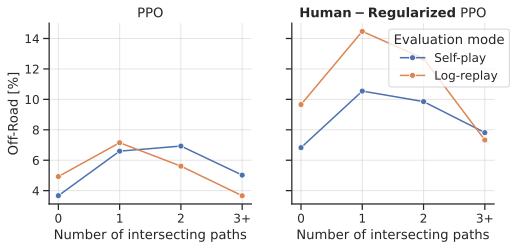

In [94]:
df_log_replay_reset = df_log_replay_agg.reset_index()
df_self_play_reset = df_self_play_agg.reset_index()

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# PPO
sns.lineplot(
    x='int_path_cat', 
    y='off_road', 
    data=df_self_play_reset[df_self_play_reset['reg_weight'] == 0.0], 
    ax=axs[0],
    marker='o',
)

sns.lineplot(
    x='int_path_cat', 
    y='off_road', 
    data=df_log_replay_reset[df_log_replay_reset['reg_weight'] == 0.0], 
    ax=axs[0],
    marker='o',
)

# HR-PPO
sns.lineplot(
    x='int_path_cat', 
    y='off_road', 
    data=df_self_play_reset[df_self_play_reset['reg_weight'] == 0.05], 
    ax=axs[1],
    marker='o',
    label='Self-play',
)

sns.lineplot(
    x='int_path_cat', 
    y='off_road', 
    data=df_log_replay_reset[df_log_replay_reset['reg_weight'] == 0.05], 
    ax=axs[1],
    marker='o',
    label='Log-replay',
)

axs[1].legend(title='Evaluation mode', loc='upper left', bbox_to_anchor=(.45, 1), facecolor='white')
axs[0].set_title('PPO')
axs[1].set_title(r'$\bf{Human - Regularized}$ PPO')
axs[0].set_ylabel('Off-Road [%]')
axs[0].set_xlabel('Number of intersecting paths')
axs[1].set_xlabel('Number of intersecting paths')
fig.subplots_adjust(bottom=0.25)
axs[1].grid(True, alpha=0.5), axs[0].grid(True, alpha=0.5)
sns.despine()

plt.savefig(f'../evaluation/figures/coordination_self_play_vs_expert_offroad.pdf', bbox_inches="tight")

In [29]:
df_self_play_agg

goal_rate   off_road  veh_veh_collision
reg_weight int_path_cat                                         
0.000      0             88.084437   3.669429           8.633239
           1             76.032083   6.597468          18.306204
           2             75.247525   6.930693          18.836030
           3+            77.854251   5.020243          17.813765
0.005      0             89.344543   3.881127           7.022319
           1             78.100181   6.503106          16.057246
           2             78.821541   7.341222          14.440956
           3+            82.388664   5.708502          12.510121
0.050      0             81.114539   6.826751           7.181596
           1             68.192184  10.544940          14.445231
           2             67.664815   9.852693          13.378411
           3+            72.348178   7.813765          13.198381
0.200      0             65.348092  10.326821           8.451783
           1             55.107337  15.255170          13.305025
           2             57.232553  14.344361          13.837237
           3+            61.781377  12.267206          12.753036